In [36]:
import os

from datetime import date, timedelta
from tqdm.auto import tqdm

import numpy as np
import pandas as pd

import networkx as nx

In [37]:
ROAD_FILE = 'road_network_sub-dataset/road_network_sub-dataset'
GPS_FILE = 'road_network_sub-dataset/link_gps'
TRAFFIC_FILE = 'traffic_speed_sub-dataset'

In [38]:
road_df = pd.read_csv(ROAD_FILE, sep='\t')

gps_df = pd.read_csv(GPS_FILE, sep='\t', header=None)
gps_df.columns = ['link_id', 'lon', 'lat']

На первый взгляд может показаться что в файле с GPS координатами все сломано: там нет ни одного id из тех что есть в файле с дорогами. 
Но кажется что когда-то файл с GPS координатами был столбцами файла с дорогами: у них одинаковый размер и столбец link_id совпадает.

In [39]:
gps_df['link_id'].isin(road_df['snodeid']).sum(), gps_df['link_id'].isin(road_df['enodeid']).sum()

(0, 0)

In [40]:
(gps_df['link_id'] == road_df['link_id']).mean(), gps_df.shape, road_df.shape

(1.0, (45148, 3), (45148, 8))

Еще кажется что это координаты концов участков дорог

In [41]:
road_df['lat'] = gps_df['lat']
road_df['lon'] = gps_df['lon']
road_df['coord'] = road_df[['lat', 'lon']].apply(tuple, axis=1)

road_df.groupby('snodeid')['coord'].nunique().max(), road_df.groupby('enodeid')['coord'].nunique().max()

(5, 1)

То есть мы знаем координаты для всех точек которые являются концом хотя бы одного участка дороги в нашем датасете. 
Осталось выкинуть дороги у которых есть точки координаты которых мы не знаем и выделить связанную компоненту.

In [42]:
gps_df = gps_df.drop('link_id', axis=1)
gps_df['node_id'] = road_df['enodeid']
gps_df = gps_df.drop_duplicates()

gps_df.shape, gps_df['node_id'].nunique()

((39198, 3), 39198)

In [46]:
road_df = road_df[road_df['snodeid'].isin(gps_df['node_id'])]

In [47]:
G = nx.Graph()
G.add_edges_from(road_df[['snodeid', 'enodeid']].apply(tuple, axis=1))

In [57]:
components = sorted(list(nx.connected_components(G)), key=lambda x: -len(x))
[len(x) for x in components[:5]]

[10034, 6731, 5474, 1319, 1258]

In [58]:
biggest_component = components[0]

In [68]:
road_df = road_df[road_df['snodeid'].isin(biggest_component) & road_df['enodeid'].isin(biggest_component)]
gps_df = gps_df[gps_df['node_id'].isin(biggest_component)]

Ну и в конце концов нарисуем этот граф)

In [69]:
G = nx.Graph()
G.add_edges_from(road_df[['snodeid', 'enodeid']].apply(tuple, axis=1))

In [87]:
pos = gps_df.set_index('node_id')[['lon', 'lat']].apply(tuple, axis=1).to_dict()

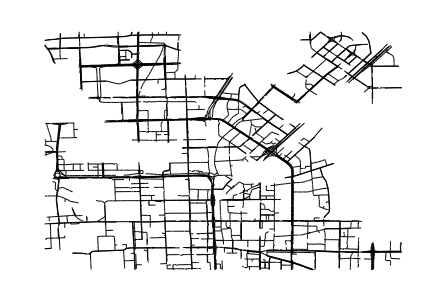

In [88]:
nx.draw(G, pos=pos, node_size=0)

In [91]:
!python3 clean_data.py

100%|█████████████████████████| 264386688/264386688 [07:07<00:00, 618580.85it/s]
